In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils import formatar_eixo_ano

root_path = str(Path.cwd().parent)
if root_path not in sys.path:
    sys.path.append(root_path)


pd.set_option("display.max_columns", None)

In [83]:
df = pd.read_parquet("../arquivos_parquet/dados_base.parquet")
df

,Close,High,Low,Open,Volume,Variacao,Var%
Date,,,,,,,
2023-01-02,14.359387,14.486581,14.178641,14.479886,544066,0.000000,0.000000
2023-01-03,14.084925,14.392865,13.971120,14.359392,899262,-0.274463,-1.911382
2023-01-04,14.098313,14.312533,14.031370,14.125091,908666,0.013389,0.095056
2023-01-05,14.513362,14.587000,14.111702,14.171951,1218768,0.415049,2.943959
2023-01-06,14.700799,14.767742,14.479884,14.546829,1122123,0.187437,1.291479
...,...,...,...,...,...,...,...
2026-02-09,44.750000,44.900002,43.500000,43.509998,1242700,1.310001,3.015657
2026-02-10,44.889999,45.669998,44.669998,44.740002,1212000,0.139999,0.312848
2026-02-11,45.730000,45.950001,45.040001,45.040001,1037800,0.840000,1.871241


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 2023-01-02 to 2026-02-13
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     780 non-null    float64
 1   High      780 non-null    float64
 2   Low       780 non-null    float64
 3   Open      780 non-null    float64
 4   Volume    780 non-null    int64  
 5   Variacao  780 non-null    float64
 6   Var%      780 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 48.8 KB


In [85]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,780.0,22.830589,6.629407,13.289885,17.046261,21.650494,27.869543,4.573000e+01
High,780.0,23.030851,6.682881,13.549456,17.174299,21.852506,28.151833,4.595000e+01
Low,780.0,22.609390,6.548710,13.175895,16.891638,21.460532,27.521535,4.504000e+01
Open,780.0,22.807413,6.603840,13.318424,17.030345,21.626127,27.877203,4.560000e+01
Volume,780.0,681482.961538,431225.041347,122364.000000,417492.250000,570521.500000,799383.000000,4.582985e+06
Variacao,780.0,0.038437,0.308911,-1.441841,-0.127443,0.028931,0.180339,1.679272e+00
Var%,780.0,0.152354,1.244402,-3.989910,-0.584093,0.138278,0.843547,6.547327e+00


#### 1. Contextualização de Preço vs. Momentum <br>

- **O "Close":** Fornece a base de valor. <br>
  No nosso dataset, ele varia entre 13.28 e 45.73, <br>
  com um desvio padrão de 6.62. Ele ancora a rede na <br>
  realidade nominal do ativo.

- **A "Var%":** É o nosso indicador de volatilidade.<br>
  Com uma média de 0.15% e picos de até 6.54%, <br>
  essa feature ajuda a LSTM a identificar <br>
  períodos de "estresse" ou "euforia" no mercado <br>
  que o preço absoluto sozinho demora a refletir.

#### 2. Redução de Ruído e Multicolinearidade <br>

- Eliminaremos as colunas Open, High e Low.
- **Insight:** Como essas variáveis são altamente correlacionadas<br>
  com o Close (multicolinearidade), mantê-las poderia <br>
  causar um sobreajuste (overfitting) sem adicionar <br>
  ganho de informação real. Ao trocá-las pela Var%, <br>
  estamos substituindo dados redundantes por uma métrica de momentum.

#### 3. Normalização Diferenciada <br>

- **Desafio:** O Close é uma série não estacionária <br>
  (tende a subir ou descer ao longo do tempo), <br>
  enquanto a Var% é estacionária (oscila em torno de zero, entre -3.98% e 6.54%).
- **A Abordagem:** Em séries temporais de alta frequência, isso indica forte correlação. <br>
  Para o nosso modelo LSTM, devido a isso, trabalharemos sob a coluna Close e var%


In [86]:
inicio = df.index.min()
fim = df.index.max()

print(f"Data inicial: {inicio}")
print(f"Data final: {fim}")

Data inicial: 2023-01-02 00:00:00
Data final: 2026-02-13 00:00:00


In [87]:
plt.rcParams["figure.figsize"] = (
    12,
    6,
)  # Tamanho padrão para todos os gráficos
plt.rcParams["axes.grid"] = True  # Ativa grade em todos
plt.rcParams["grid.alpha"] = 0.3  # Transparência da grade
plt.rcParams["axes.titlesize"] = 14  # Tamanho da fonte do título

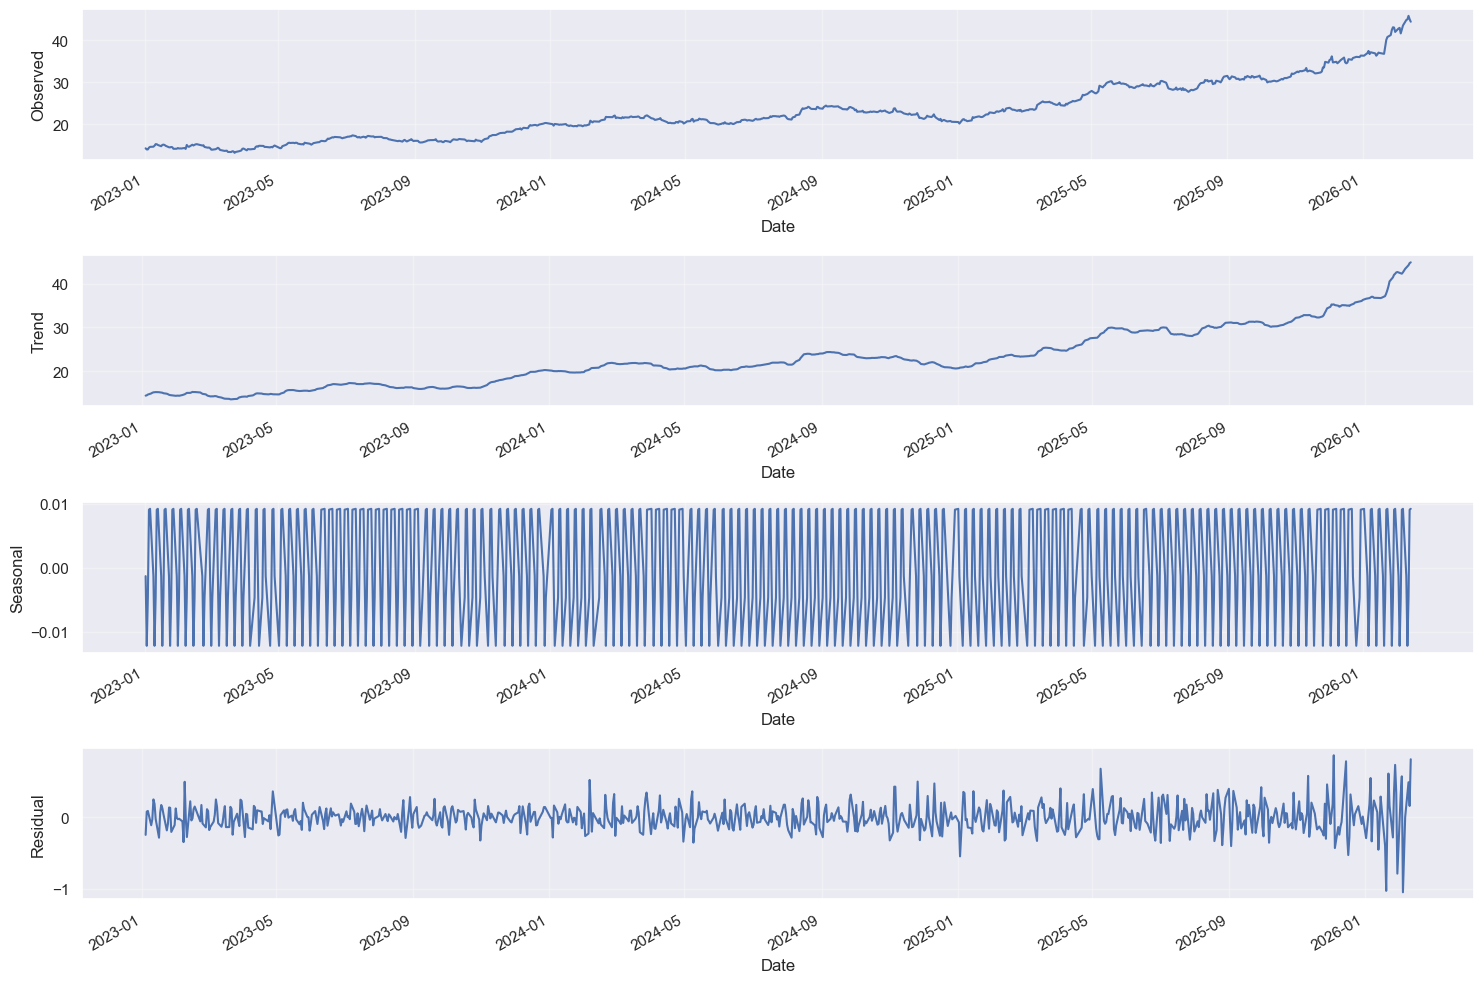

In [88]:
# Decomposição da série temporal
result = seasonal_decompose(df["Close"], model="additive", period=5)

# Plotando os componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
result.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel("Observed")
result.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel("Trend")
result.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel("Seasonal")
result.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel("Residual")
plt.tight_layout()
plt.show()

#### 1. Dominância da Tendência (Trend) sobre o Ruído

- **O Insight:** O gráfico de Trend mostra uma tendência <br>
  de alta clara e consistente, saindo de aproximadamente <br>
  15 no início de 2023 para ultrapassar 40 no início de 2026.

- **Implicação para ML:** Isso confirma que o ativo não é estacionário.<br>
  Para a LSTM, isso reforça a necessidade de normalização, <br>
  mas também indica que o modelo terá uma "direção" forte para aprender. <br>
  O fato de a tendência ser suave (sem quebras estruturais abruptas) <br>
  é um excelente sinal para a estabilidade do treinamento.

#### 2. Sazonalidade de Alta Frequência

- **O Insight:** O componente Seasonal revela um padrão cíclico <br>
  extremamente regular e repetitivo em intervalos muito curtos.
- **Implicação para ML:** Essa oscilação constante entre -0.01 e 0.01 <br>
  sugere padrões semanais ou mensais muito rígidos. A LSTM é ideal aqui <br>
  porque sua arquitetura de "portões" (gates) consegue memorizar essa periodicidade,<br>
  permitindo que o modelo antecipe pequenas correções ou subidas cíclicas que <br>
  ocorrem independentemente da tendência principal.

#### 3. Análise de Resíduos (Ruído) e Volatilidade Recente

- **O Insight:** O gráfico de Residual mostra que o erro não explicado (ruído)<br>
  era estável até meados de 2025, mas apresenta um aumento significativo de <br>
  volatilidade no final do período (início de 2026), com variações atingindo -1.
- **Implicação para ML:** Este é o insight mais crítico para o nosso "lookback window".<br>
  O aumento do ruído no final da série indica que eventos recentes são mais imprevisíveis. <br>
  Isso justifica o uso da feature Var% (escolhida anteriormente), <br>
  pois ela ajudará a rede a entender esses choques de volatilidade <br>
  que o componente de tendência não consegue explicar.


In [89]:
print("Resultado Dickey-Fuller VAR%")
resultado_var = adfuller(df["Var%"])
print(f"ADF Statistic: {resultado_var[0]}")
print(f"p-valor: {resultado_var[1]}")
print("Critical Values:")
for key, value in resultado_var[4].items():
    print(f"   {key}: {value}")

print("\nResultado Dickey-Fuller Close")
resultado_close = adfuller(df["Close"])
print(f"ADF Statistic: {resultado_close[0]}")
print(f"p-valor: {resultado_close[1]}")
print("Critical Values:")
for key, value in resultado_close[4].items():
    print(f"   {key}: {value}")

Resultado Dickey-Fuller VAR%
ADF Statistic: -27.418621192166533
p-valor: 0.0
Critical Values:
   1%: -3.4387723094153286
   5%: -2.8652573313919625
   10%: -2.5687494684274794

Resultado Dickey-Fuller Close
ADF Statistic: 2.6439330052138623
p-valor: 0.9990819947063985
Critical Values:
   1%: -3.438837902109151
   5%: -2.8652862410999114
   10%: -2.568764869203001


### Diagnóstico Estatístico: ADF Test

- Os resultados para Var% e Close apresentam comportamentos opostos, <br>
  o que é ideal para o nosso modelo multivariado.

#### 1. Var%: Estacionaridade Perfeita

- O teste para a Variação Percentual retornou um p-valor de 0.0 <br>
  e uma estatística ADF de -27.41.
- **Insight:** Este valor está drasticamente abaixo dos valores críticos (mesmo a 1%),<br>
  o que significa que rejeitamos a hipótese nula com extrema confiança.

- **Significado para a LSTM:** A Var% é uma série estacionária. Isso fornece à rede um<br>
  sinal de "momentum" consistente e previsível, onde as oscilações têm média zero e<br>
  variância controlada. É a feature perfeita para ajudar o modelo a entender a <br>
  volatilidade de curto prazo.

#### 2. Close: Presença de Tendência (Não-Estacionária)

- O teste para o preço de Fechamento retornou um p-valor de ~0.999 <br>
  e uma estatística ADF de 2.64.
- **Insight:** Como o p-valor é muito superior a 0.05, <br>
  não podemos rejeitar a hipótese nula. Isso confirma estatisticamente<br>
  a tendência de alta que vimos no gráfico de decomposição.

- **Significado para a LSTM:** Redes neurais podem ter dificuldade <br>
  com dados não-estacionários que "fogem" do intervalo conhecido. <br>
  Isso torna o passo de Normalização (MinMaxScaler) obrigatório <br>
  para o Close, garantindo que o modelo aprenda a relação<br>
  de crescimento sem se perder em valores nominais cada vez maiores.


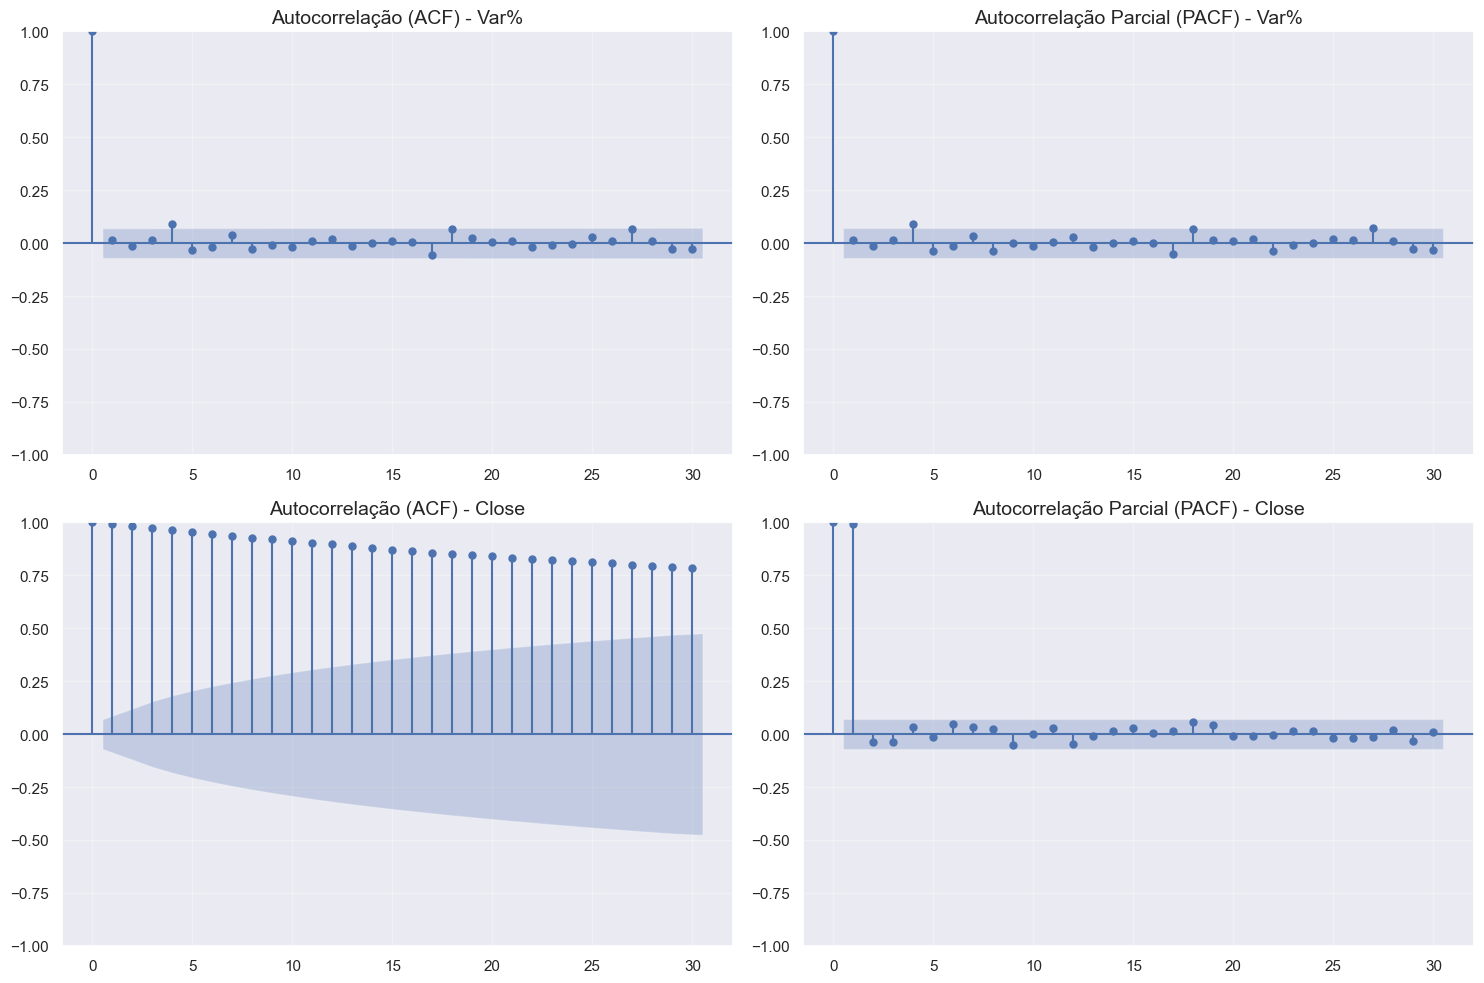

In [90]:
# Criando o ambiente 2x2 e achatando os eixos para facilitar o acesso
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

# ACF / PACF Var%
plot_acf(df["Var%"], lags=30, ax=ax1)
ax1.set_title("Autocorrelação (ACF) - Var%")

plot_pacf(df["Var%"], lags=30, ax=ax2)
ax2.set_title("Autocorrelação Parcial (PACF) - Var%")

# ACF / PACF Close
plot_acf(df["Close"], lags=30, ax=ax3)
ax3.set_title("Autocorrelação (ACF) - Close")

plot_pacf(df["Close"], lags=30, ax=ax4)
ax4.set_title("Autocorrelação Parcial (PACF) - Close")

plt.tight_layout()
plt.show()

#### 1. Close: Dominância do Passado Imediato

- Os gráficos do Close confirmam a natureza não-estacionária<br>
  que o teste ADF já havia apontado.
- **ACF - Close:** Apresenta uma queda extremamente lenta e gradual, <br>
  com todos os 30 lags bem acima da zona de significância azul. <br>
  Isso indica uma série com memória longa e forte persistência de tendência.
- **PACF - Close:** Aqui está o ponto principal. Note que existe um pico enorme <br>
  no Lag 1 e, logo em seguida, os valores despencam para dentro da zona de significância.
- **Insight de Engenharia:** Isso indica que o preço de hoje é fortemente <br>
  explicado pelo preço de ontem (modelo autorregressivo de ordem 1). <br>
  Para a LSTM, isso significa que não precisamos de janelas gigantescas<br>
  para prever o próximo valor, pois a informação mais relevante está no passado muito recente.

#### 2. Var%: Ruído Branco e Sazonalidade Curta

- A Variação Percentual se comporta de forma oposta,<br>
  confirmando sua estacionaridade.
- **ACF/PACF - Var%:** A maioria dos lags cai rapidamente para dentro da área azul.<br>
  No entanto, observe pequenos picos significativos (que saem da zona azul) por volta do Lag 4 e Lag 5.
- **Insight de Engenharia:** Esses picos sugerem uma sazonalidade semanal (considerando <br>
  dias úteis da bolsa).Isso justifica configurarmos nossa janela de observação <br>
  (lookback window) para capturar pelo menos uma semana inteira de negociação.


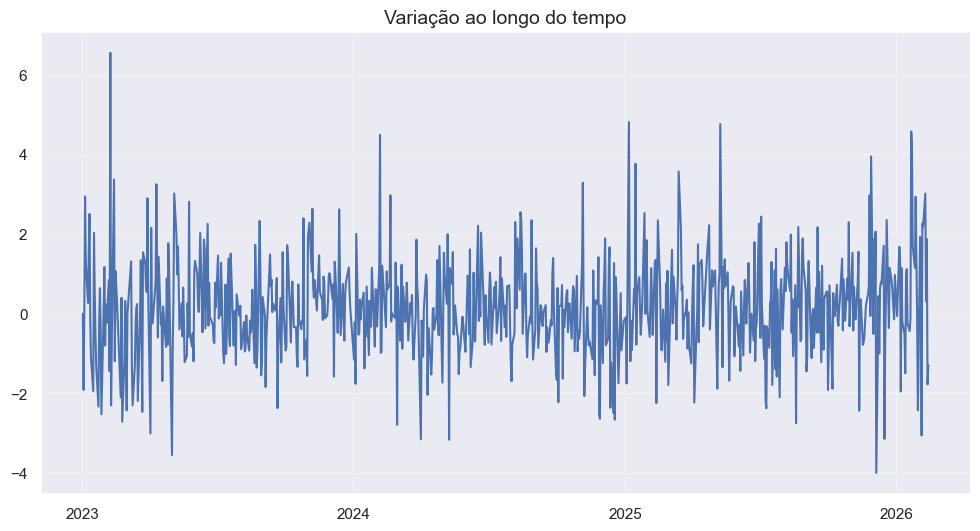

In [91]:
fig, ax = plt.subplots()
ax.plot(df["Var%"])

formatar_eixo_ano(ax)

ax.set_title("Variação ao longo do tempo")
plt.show()

#### 1. Assinatura de Estacionaridade Confirmada

- **O Insight:** O gráfico demonstra que a Var% oscila de forma consistente<br>
  em torno da média zero durante todo o intervalo de 2023 a 2026.
- **Relevância para ML:** Esta estabilidade visual corrobora o p-valor de 0.0 <br>
  obtido no teste Dickey-Fuller. Enquanto o preço de fechamento (Close) "foge" <br>
  para cima em uma tendência clara, a variação é um sinal autolimitado. <br>
  Para a nossa LSTM, isso significa que a Var% servirá como um excelente <br>
  normalizador de contexto, informando à rede se o movimento atual é uma <br>
  anomalia ou parte do ruído padrão do mercado.


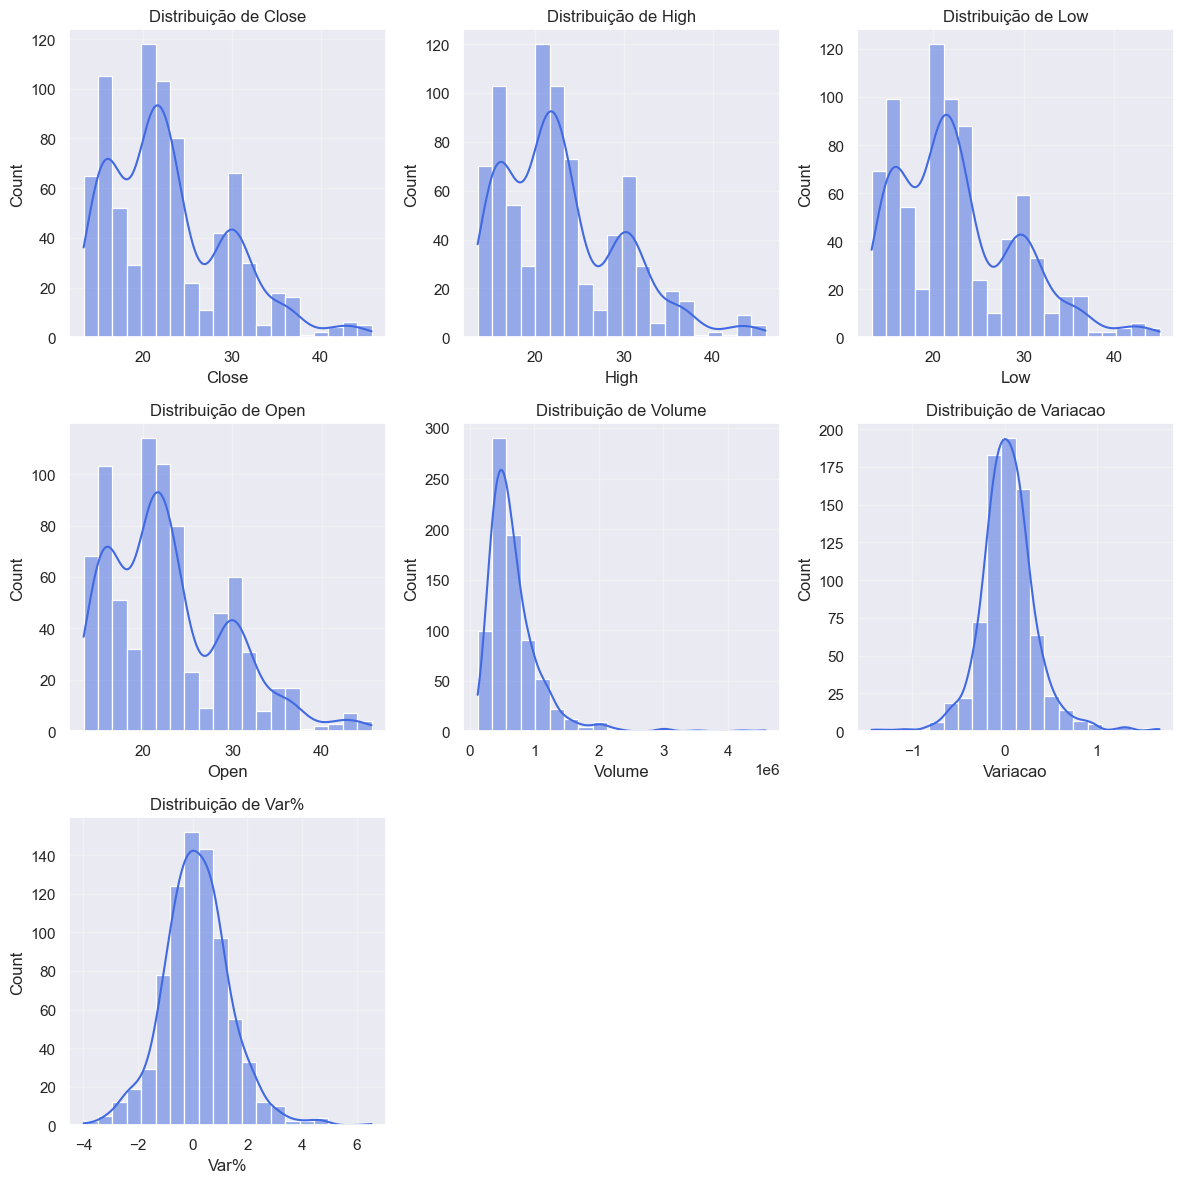

In [92]:
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

columns = ["Close", "High", "Low", "Open", "Volume", "Variacao", "Var%"]

for i, col in enumerate(columns):
    sns.histplot(df[col], kde=True, ax=axes[i], color="royalblue", bins=20)
    axes[i].set_title(f"Distribuição de {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 1. Perfil de Distribuição e Caudas Longas

- **Preços (Close, Open, High, Low):** Apresentam uma distribuição multimodal com uma cauda longa à direita<br>
  (assimetria positiva). A maior densidade de dados está na faixa de 20 a 25, <br>
  mas há uma dispersão significativa até o valor máximo de 45.73.
- **Volume:** Apresenta uma assimetria extrema. A vasta maioria dos dias tem volumes <br>
  baixos, mas existem picos (outliers) que chegam a 4.58 milhões.

#### 2. Estacionaridade e Comportamento Gaussiano

- **Variação (Var%):** O histograma da Var% é o que mais se aproxima de uma <br>
  Distribuição Normal (Gaussiana), centrada próxima a zero. Isso confirma estatisticamente <br>
  por que o teste ADF retornou estacionaridade perfeita para esta variável. <br>
  Modelos de Deep Learning aprendem muito mais rápido com sinais que possuem <br>
  média e variância estáveis como este.


In [ ]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(figsize=(12, 6))
sns.boxplot(x="Var%", data=df)
axes.set_title("Boxplot")
plt.show()

fig, axes = plt.subplots(figsize=(12, 6))
sns.violinplot(x="Close", data=df, color="gray")
axes.set_title("Violin plot")
plt.show()

#### 1. Robustez do Modelo vs. Outliers (Boxplot - Var%)

- O Boxplot da Var% revela uma distribuição centralizada, <br>
  mas com uma presença significativa de "pontos fora da curva" em ambos os extremos.
- **O Diagnóstico:** Embora a mediana esteja próxima de zero, <br>
  identificamos outliers que chegam a $+6\%$ e $-4\%$. <br>
  Esses outliers são perigosos para uma LSTM se não forem tratados.<br>
  será verificado a melhor função de perdas, pois se usarmos **MSE** <br>
  ao invés de **MAE**, o modelo pode desastabilizar uma vez que <br>
  tentará perseguir esses picos.

#### 2. Geometria da Densidade e Multimodalidade (Violin Plot - Close)

- O Violin Plot do Close oferece uma visão muito mais rica que um histograma comum,<br>
  mostrando a "massa" de dados ao longo do preço.
- **O Diagnóstico:** Notamos três alargamentos na distribuição (por volta de 17, 22 e 30),<br>
  indicando que o preço tende a se consolidar nessas faixas antes de romper para o próximo nível.
- **Insight:** A "cauda" fina que se estende até quase 50 <br>
  mostra que o ativo está em território de descoberta de preços recentes.<br>
  Como a densidade de dados diminui significativamente acima de 35, <br>
  a rede terá menos exemplos para aprender o comportamento em preços altos. <br>
  Isso reforça a estratégia de usar a Var% como entrada, pois o "comportamento" <br>
  de variação costuma ser mais consistente do que o valor nominal do preço em regiões novas.


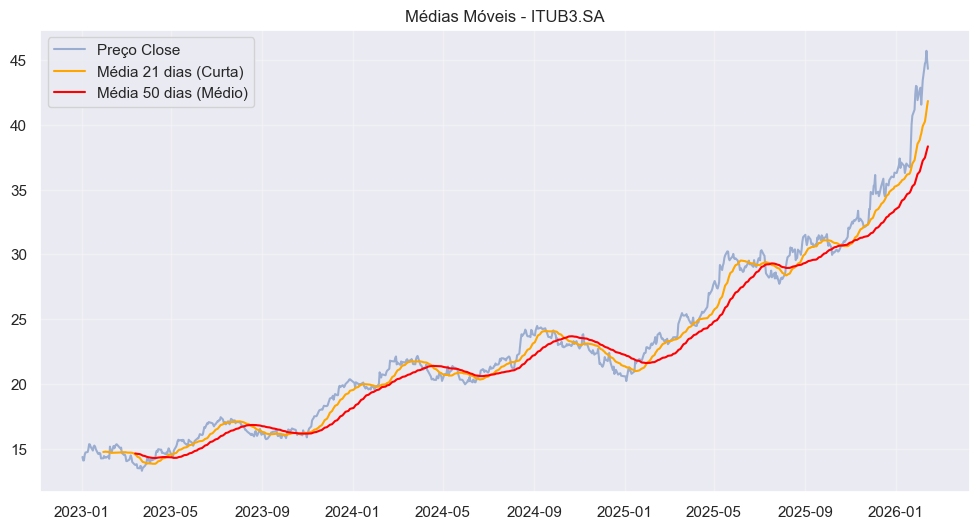

In [ ]:
df["MA21"] = df["Close"].rolling(window=21).mean()  # 1 Mês
df["MA50"] = df["Close"].rolling(window=50).mean()  # 1 Trimestre


# Plotando
plt.figure(figsize=(12, 6))
plt.plot(df["Close"], label="Preço Close", alpha=0.5)
plt.plot(df["MA21"], label="Média 21 dias (Curta)", color="orange")
plt.plot(df["MA50"], label="Média 50 dias (Médio)", color="red")
plt.title("Médias Móveis - ITUB3.SA")
plt.legend()
plt.show()

### Diagnóstico de Engenharia: Médias Móveis e Tendência

- O gráfico de Médias Móveis do ativo ITUB3.SA revela a <br>
  estrutura de suporte e a inércia do preço:

#### 1. Confirmação de Tendência de Alta Sustentada.

- **O Insight:** O preço de fechamento (Close) permanece consistentemente<br>
  acima das médias de 21 dias (curta) e 50 dias (média) durante a maior <br>
  parte do período de 2023 a 2026.
- **Relevância para ML:** Isso ratifica o teste ADF, que indicou uma série não-estacionária. <br>
  Como o preço está "esticado" em relação às médias no início de 2026, a nossa LSTM <br>
  deve ser capaz de identificar se este é um movimento de exaustão ou uma nova <br>
  fase de aceleração.

#### 2. Cruzamento de Médias e Momentum

- **O Insight:** Observamos que a média curta (laranja) raramente cruza abaixo da média<br>
  média (vermelha), atuando como um suporte dinâmico para o preço.
- **Relevância para ML:** Essas médias são excelentes features auxiliares. Elas fornecem à<br>
  rede neural uma visão "suavizada" da tendência, o que ajuda a filtrar o ruído diário <br>
  que vimos no gráfico de Var%.

#### 3. Sincronização com o Lookback Window

- **O Insight:** A média de 21 dias captura o ciclo mensal de negociação.
- **Decisão Técnica:** Dado que o nosso PACF sugeriu relevância até o lag 15, utilizar uma<br>
  média móvel de 21 dias como uma feature adicional pode enriquecer o modelo, dando a <br>
  ele uma noção de contexto mensal dentro de uma janela de observação quinzenal.
